In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/processed/lending_club_clean.csv")

df.shape

(396030, 38)

In [4]:
X = df.drop("default_flag", axis=1)
y = df["default_flag"]

X.shape, y.shape

((396030, 37), (396030,))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_train.mean(), y_test.mean()

(0.19612781859960104, 0.19613413125268286)

In [6]:
log_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1
    ))
])

In [7]:
log_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1))])

In [8]:
y_pred_proba = log_pipeline.predict_proba(X_test)[:, 1]

In [9]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc

0.7053397833650583

In [10]:
y_pred = (y_pred_proba >= 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[42281, 21390],
       [ 5672,  9863]], dtype=int64)

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.66      0.76     63671
           1       0.32      0.63      0.42     15535

    accuracy                           0.66     79206
   macro avg       0.60      0.65      0.59     79206
weighted avg       0.77      0.66      0.69     79206



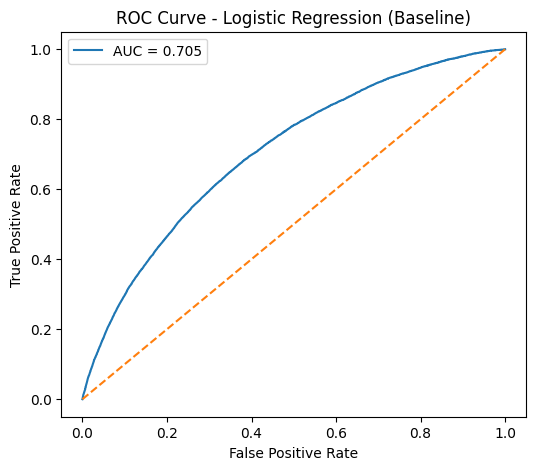

In [12]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Baseline)")
plt.legend()
plt.show()

### Model Interpretation

In [13]:
coefficients = log_pipeline.named_steps["log_reg"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coefficients
})

coef_df = coef_df.sort_values(by="Coefficient", ascending=False)

coef_df.head(10)

,Feature,Coefficient
6,dti,0.469512
2,int_rate,0.446723
1,term,0.236045
3,installment,0.111334
7,open_acc,0.107287
14,issue_year,0.105838
10,revol_util,0.094422
33,purpose_small_business,0.082624
21,verification_status_Source Verified,0.072515
20,home_ownership_RENT,0.061152


In [14]:
coef_df["Odds_Ratio"] = np.exp(coef_df["Coefficient"])

coef_df.head(10)

,Feature,Coefficient,Odds_Ratio
6,dti,0.469512,1.599214
2,int_rate,0.446723,1.563182
1,term,0.236045,1.266232
3,installment,0.111334,1.117768
7,open_acc,0.107287,1.113253
14,issue_year,0.105838,1.111642
10,revol_util,0.094422,1.099024
33,purpose_small_business,0.082624,1.086133
21,verification_status_Source Verified,0.072515,1.075209
20,home_ownership_RENT,0.061152,1.063061


### Baseline Logistic Regression – Preliminary Interpretation

A Logistic Regression model is implemented as the baseline classifier to establish reference performance and interpretability.

The estimated coefficients indicate:

- Higher DTI and interest rates increase default probability.  
- Longer loan terms are associated with higher risk.  
- Higher annual income reduces default likelihood.  

These findings are consistent with fundamental credit risk principles, where leverage and repayment capacity drive default behavior.

Logistic Regression is used as the baseline model due to its transparency and common application in traditional credit risk modeling. This serves as a benchmark for model comparison in the next phase.